In [1]:
import pandas as pd
import numpy as np
import os
import sys

# Add path to import EquiBoots
script_path = os.path.abspath("../py_scripts")
print("Appending path:", script_path)
sys.path.append(script_path)

Appending path: /Users/afunnell/Code/equiboots/py_scripts


In [2]:
import equiboots as eqb

from equiboots.tables import metrics_table

In [3]:
import numpy as np
import pandas as pd

def generate_biased_synthetic_data(n_samples=1000, bias_strength='moderate', random_seed=42):
    """
    Generate synthetic data with intentional bias to create statistically significant differences.
    
    Parameters:
    - n_samples: Number of samples to generate
    - bias_strength: 'mild', 'moderate', or 'strong' - controls the level of bias
    - random_seed: For reproducibility
    """
    np.random.seed(random_seed)
    
    # Define bias parameters based on strength
    bias_params = {
        'mild': {'race_bias': 0.15, 'sex_bias': 0.08, 'noise_level': 0.3},
        'moderate': {'race_bias': 0.25, 'sex_bias': 0.15, 'noise_level': 0.2},
        'strong': {'race_bias': 0.4, 'sex_bias': 0.25, 'noise_level': 0.1}
    }
    
    params = bias_params[bias_strength]
    
    # Generate demographic variables
    race = np.random.choice(["white", "black", "asian", "hispanic"], n_samples, 
                           p=[0.4, 0.3, 0.15, 0.15]).reshape(-1, 1)
    sex = np.random.choice(["M", "F"], n_samples, p=[0.5, 0.5]).reshape(-1, 1)
    
    # Create bias mappings
    race_bias_map = {
        "white": 0.0,      # baseline
        "black": -params['race_bias'],    # disadvantaged
        "asian": params['race_bias'] * 0.5,  # slight advantage
        "hispanic": -params['race_bias'] * 0.7  # disadvantaged
    }
    
    sex_bias_map = {
        "M": params['sex_bias'] * 0.5,   # slight advantage
        "F": -params['sex_bias'] * 0.5   # slight disadvantage
    }
    
    # Generate base probabilities with bias
    base_prob = 0.5  # neutral starting point
    
    # Apply demographic biases
    race_adjustments = np.array([race_bias_map[r[0]] for r in race])
    sex_adjustments = np.array([sex_bias_map[s[0]] for s in sex])
    
    # Combine biases with some noise
    noise = np.random.normal(0, params['noise_level'], n_samples)
    
    # Calculate biased probabilities
    y_prob = base_prob + race_adjustments + sex_adjustments + noise
    
    # Clip to valid probability range
    y_prob = np.clip(y_prob, 0.01, 0.99)
    
    # Generate predictions and true labels based on biased probabilities
    y_pred = (y_prob > 0.5).astype(int)
    
    # Make true labels correlated with the biased probabilities to simulate real bias
    # Add some randomness to make it realistic
    true_label_prob = y_prob * 0.8 + np.random.uniform(0, 0.4, n_samples)
    true_label_prob = np.clip(true_label_prob, 0.01, 0.99)
    y_true = np.random.binomial(1, true_label_prob)
    
    return y_true, y_prob, y_pred, race, sex



In [4]:
y_true, y_prob, y_pred, race, sex = generate_biased_synthetic_data(
    n_samples=1000, 
    bias_strength='moderate',  # Try 'mild', 'moderate', or 'strong'
    random_seed=42
)

# Create fairness DataFrame
fairness_df = pd.DataFrame(
    data=np.concatenate((race, sex), axis=1), 
    columns=["race", "sex"]
)


# Initialize and process groups
eq = eqb.EquiBoots(
    y_true=y_true,
    y_prob=y_prob,
    y_pred=y_pred,
    fairness_df=fairness_df,
    fairness_vars=["race", "sex"],
)
eq.grouper(groupings_vars=["race", "sex"])

Groups created


In [5]:
sliced_race_data = eq.slicer("race")
race_metrics = eq.get_metrics(sliced_race_data)

sliced_sex_data = eq.slicer("sex")
sex_metrics = eq.get_metrics(sliced_sex_data)

In [6]:
test_config = {
    "test_type": "chi_square",
    "alpha": 0.05,
    "adjust_method": "bonferroni",
    "confidence_level": 0.95,
    "classification_task": "binary_classification",
}
stat_test_results_race = eq.analyze_statistical_significance(
    race_metrics, "race", test_config
)

stat_test_results_sex = eq.analyze_statistical_significance(
    sex_metrics, "sex", test_config
)

In [7]:
stat_test_results_race

{'omnibus': StatTestResult(statistic=224.80723962712176, p_value=8.156186456460238e-43, is_significant=True, test_name='Chi-Square Test', critical_value=None, effect_size=0.2737439433893907, confidence_interval=None),
 'hispanic': StatTestResult(statistic=58.54116074806115, p_value=4.8185506708295956e-12, is_significant=True, test_name='Chi-Square Test', critical_value=None, effect_size=0.3193557341381798, confidence_interval=None),
 'asian': StatTestResult(statistic=25.16860583529919, p_value=5.69461243607568e-05, is_significant=True, test_name='Chi-Square Test', critical_value=None, effect_size=0.21276107887062612, confidence_interval=None),
 'black': StatTestResult(statistic=111.22279329502825, p_value=2.3945705463873755e-23, is_significant=True, test_name='Chi-Square Test', critical_value=None, effect_size=0.3952363702086561, confidence_interval=None)}

In [8]:
stat_test_results_sex

{'omnibus': StatTestResult(statistic=63.913721542946405, p_value=1.7128569617157585e-13, is_significant=True, test_name='Chi-Square Test', critical_value=None, effect_size=0.252811632530915, confidence_interval=None),
 'M': StatTestResult(statistic=63.913721542946405, p_value=1.7128569617157585e-13, is_significant=True, test_name='Chi-Square Test', critical_value=None, effect_size=0.252811632530915, confidence_interval=None)}

In [9]:
overall_stat_results = {"sex": stat_test_results_sex, "race": stat_test_results_race}

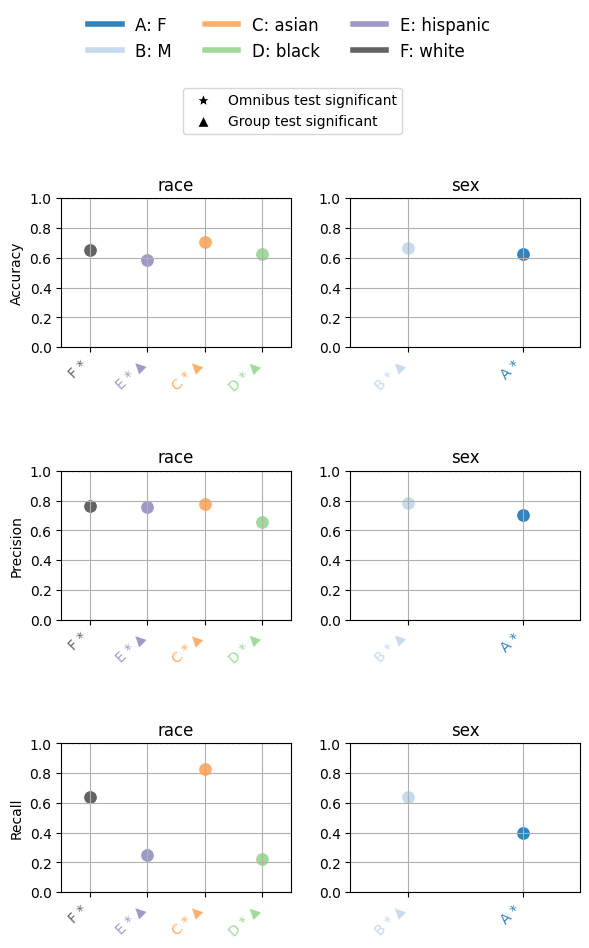

In [10]:
# Run with custom y_lim and adjusted thresholds
eqb.eq_group_metrics_point_plot(
    group_metrics=[race_metrics, sex_metrics],
    metric_cols=[
        "Accuracy",
        "Precision",
        "Recall",
    ],
    category_names=["race", "sex"],
    figsize=(6, 8),
    include_legend=True,
    plot_thresholds=(0.9, 1.1),
    raw_metrics=True,
    show_grid=True,
    y_lim=(0, 1),
    statistical_tests=overall_stat_results
)

In [11]:
metrics_table(race_metrics, statistical_tests=stat_test_results_race, reference_group="white")

white *  hispanic * ▲  asian * ▲   black * ▲
Accuracy                   0.655582      0.588235   0.703704    0.628866
Precision                  0.762557      0.760000   0.776699    0.658537
Recall                     0.642308      0.250000   0.824742    0.223140
F1 Score                   0.697286      0.376238   0.800000    0.333333
Specificity                0.677019      0.922078   0.394737    0.917647
TP Rate                    0.642308      0.250000   0.824742    0.223140
FP Rate                    0.322981      0.077922   0.605263    0.082353
FN Rate                    0.357692      0.750000   0.175258    0.776860
TN Rate                    0.677019      0.922078   0.394737    0.917647
TP                       167.000000     19.000000  80.000000   27.000000
FP                        52.000000      6.000000  23.000000   14.000000
FN                        93.000000     57.000000  17.000000   94.000000
TN                       109.000000     71.000000  15.000000  156.000000
Prevalence                 0.617577      0.496732   0.718519    0.415808
Predicted Prevalence       0.520190      0.163399   0.762963    0.140893
ROC AUC                    0.713187      0.673616   0.668475    0.726349
Average Precision Score    0.794003      0.677329   0.849831    0.624055
Log Loss                   0.625389      0.823800   0.572701    0.680504
Brier Score                0.218167      0.265608   0.198621    0.233326

In [12]:
int_list = np.linspace(0, 100, num=10, dtype=int).tolist()
eq2 = eqb.EquiBoots(
    y_true,
    y_pred,
    fairness_df,
    ["race", "sex"],
    y_prob,
    seeds=int_list,
    reference_groups=["white", "M"],
    task="binary_classification",
    bootstrap_flag=True,
    num_bootstraps=1000,
    boot_sample_size=1000,
    balanced=True,  # False is stratified, True is balanced
    # stratify_by_outcome=True,
)

# Set seeds
eq2.set_fix_seeds(int_list)
print("seeds", eq2.seeds)

eq2.grouper(groupings_vars=["race", "sex"])

boots_race_data = eq2.slicer("race")
race_metrics = eq2.get_metrics(boots_race_data)
dispa = eq2.calculate_disparities(race_metrics, "race")

seeds [0, 11, 22, 33, 44, 55, 66, 77, 88, 100]


Bootstrapping iterations: 100%|██████████| 1000/1000 [00:01<00:00, 949.65it/s]


Groups created


In [13]:
diffs = eq2.calculate_differences(race_metrics, "race")


In [14]:
metrics_boot = ['Accuracy_diff', "Precision_diff", "Recall_diff"]


test_config = {
    "test_type": "bootstrap_test",
    "alpha": 0.05,
    "adjust_method": "bonferroni",
    "confidence_level": 0.95,
    "classification_task": "binary_classification",
    "tail_type": "two_tailed",
    "metrics": metrics_boot,
}

stat_test_results = eq.analyze_statistical_significance(
    race_metrics, "race", test_config, diffs
)

In [15]:
stat_test_results

{'hispanic': {'Accuracy_diff': StatTestResult(statistic=-0.06160000000000002, p_value=0.0, is_significant=True, test_name='bootstrap_mean', critical_value=None, effect_size=None, confidence_interval=(-0.15337655620367746, 0.03017655620367741)),
  'Precision_diff': StatTestResult(statistic=0.006086344823399714, p_value=1.0, is_significant=False, test_name='bootstrap_mean', critical_value=None, effect_size=None, confidence_interval=(-0.1328678614258402, 0.1450405510726396)),
  'Recall_diff': StatTestResult(statistic=-0.3978213477483664, p_value=0.0, is_significant=True, test_name='bootstrap_mean', critical_value=None, effect_size=None, confidence_interval=(-0.4821124547420439, -0.31353024075468894))},
 'asian': {'Accuracy_diff': StatTestResult(statistic=0.030399999999999986, p_value=1.0, is_significant=False, test_name='bootstrap_mean', critical_value=None, effect_size=None, confidence_interval=(-0.05913925517414949, 0.11993925517414945)),
  'Precision_diff': StatTestResult(statistic=0.0

In [16]:
race_metrics

[{'white': {'Accuracy': 0.684,
   'Precision': 0.7481481481481481,
   'Recall': 0.6917808219178082,
   'F1 Score': 0.7188612099644128,
   'Specificity': 0.6730769230769231,
   'TP Rate': 0.6917808219178082,
   'FP Rate': 0.3269230769230769,
   'FN Rate': 0.3082191780821918,
   'TN Rate': 0.6730769230769231,
   'TP': 101,
   'FP': 34,
   'FN': 45,
   'TN': 70,
   'Prevalence': 0.584,
   'Predicted Prevalence': 0.54,
   'ROC AUC': 0.6988277133825079,
   'Average Precision Score': 0.755149235382231,
   'Log Loss': 0.6260020100249253,
   'Brier Score': 0.21949169989981884},
  'hispanic': {'Accuracy': 0.62,
   'Precision': 0.84,
   'Recall': 0.32558139534883723,
   'F1 Score': 0.4692737430167598,
   'Specificity': 0.9338842975206612,
   'TP Rate': 0.32558139534883723,
   'FP Rate': 0.06611570247933884,
   'FN Rate': 0.6744186046511628,
   'TN Rate': 0.9338842975206612,
   'TP': 42,
   'FP': 8,
   'FN': 87,
   'TN': 113,
   'Prevalence': 0.516,
   'Predicted Prevalence': 0.2,
   'ROC AUC': 0

In [17]:
diffs

[{'hispanic': {'Accuracy_diff': -0.06400000000000006,
   'Precision_diff': 0.09185185185185185,
   'Recall_diff': -0.366199426568971,
   'F1_Score_diff': -0.24958746694765305,
   'Specificity_diff': 0.260807374443738,
   'TP_Rate_diff': -0.366199426568971,
   'FP_Rate_diff': -0.2608073744437381,
   'FN_Rate_diff': 0.366199426568971,
   'TN_Rate_diff': 0.260807374443738,
   'Prevalence_diff': -0.06799999999999995,
   'Predicted_Prevalence_diff': -0.34,
   'ROC_AUC_diff': -0.006150411825713742,
   'Average_Precision_Score_diff': -0.03341062470447753,
   'Log_Loss_diff': 0.16664338830601544,
   'Brier_Score_diff': 0.0366926859175237},
  'asian': {'Accuracy_diff': 0.03199999999999992,
   'Precision_diff': 0.03685185185185191,
   'Recall_diff': 0.15686782673084043,
   'F1_Score_diff': 0.0967232056200028,
   'Specificity_diff': -0.33461538461538465,
   'TP_Rate_diff': 0.15686782673084043,
   'FP_Rate_diff': 0.3346153846153846,
   'FN_Rate_diff': -0.15686782673084043,
   'TN_Rate_diff': -0.33

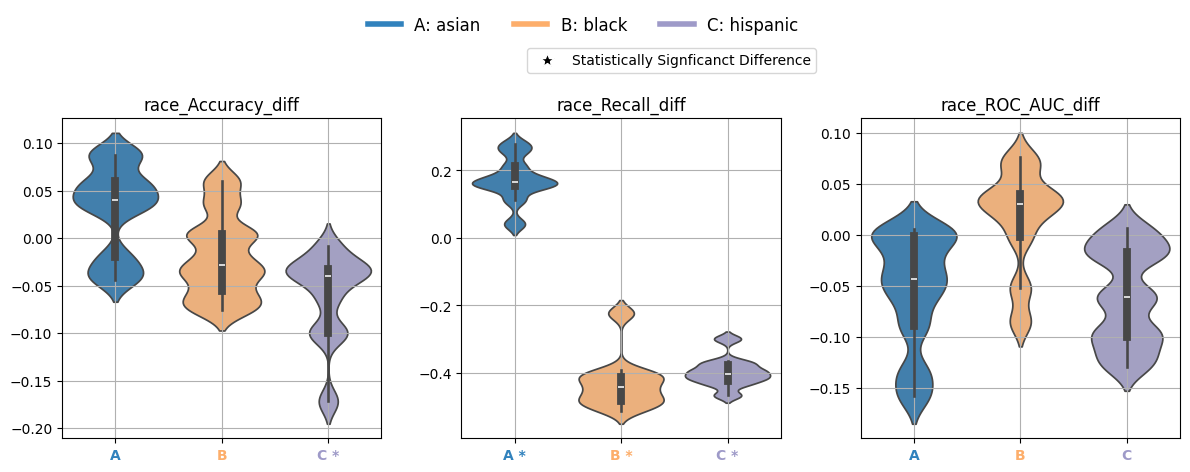

In [18]:
eqb.eq_group_metrics_plot(
    group_metrics=diffs,
    metric_cols=[
        "Accuracy_diff",
        "Recall_diff",
        "ROC_AUC_diff"
    ],
    name="race",
    categories="all",
    figsize=(12, 4),
    plot_type="violinplot",
    color_by_group=True,
    show_grid=True,
    strict_layout=True,
    save_path="./images",
    show_pass_fail=False,
    statistical_tests=stat_test_results
)

In [19]:
metrics_table(race_metrics, statistical_tests=stat_test_results, differences=diffs, reference_group="white")

asian     hispanic        black
Accuracy_diff                     0.0304  -0.061600 *      -0.0188
Precision_diff                  0.018489     0.006086    -0.122599
Recall_diff                   0.172338 *  -0.397821 *  -0.428352 *
F1_Score_diff                   0.098375    -0.321455    -0.371676
Specificity_diff               -0.303089     0.241809      0.23549
TP_Rate_diff                    0.172338    -0.397821    -0.428352
FP_Rate_diff                    0.303089    -0.241809     -0.23549
FN_Rate_diff                   -0.172338     0.397821     0.428352
TN_Rate_diff                   -0.303089     0.241809      0.23549
Prevalence_diff                   0.1204      -0.1112      -0.1988
Predicted_Prevalence_diff         0.2492      -0.3536       -0.376
ROC_AUC_diff                   -0.054813    -0.060209     0.015968
Average_Precision_Score_diff    0.064517    -0.126165    -0.174832
Log_Loss_diff                  -0.049071     0.196754     0.023626
Brier_Score_diff               -0.017095     0.045801     0.005597